In [4]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image, ImageDraw
import xml.etree.ElementTree as ET
import cv2
from torch.utils.data import Dataset
from pathlib import Path
import os
import random
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision.utils import draw_bounding_boxes
import matplotlib.patches as patches
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset

In [2]:
labels_dir = '/kaggle/input/swimming-pool-detection-algarves-landscape/labels/' 
images_dir = '/kaggle/input/swimming-pool-detection-algarves-landscape/images/'
root_dir = '/kaggle/input/swimming-pool-detection-algarves-landscape/'

In [3]:
train_transforms = A.Compose([
    A.Resize(height=128, width=128),
    A.RandomCrop(height=128, width=128, p=0.2),
    A.HorizontalFlip(p=0.2),
    A.RandomBrightnessContrast(p=0.2),
    A.Blur(always_apply=False, p=1.0, blur_limit=(3, 7)),
    A.HueSaturationValue(always_apply=False, p=1.0, hue_shift_limit=(-20, 20), sat_shift_limit=(-30, 30), val_shift_limit=(-20, 20)),
    A.Rotate(limit=30, p=0.2),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))

test_transforms = A.Compose([
    A.Resize(height=128, width=128),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),  # Match training normalization
    ToTensorV2()
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))

In [4]:
def show_transformed_image(dataset, idx):
    """
    Display a transformed image from the dataset along with its bounding boxes.

    Args:
        dataset (pool_sat_Dataset): The dataset object.
        idx (int): The index of the image to display.

    Returns:
        None
    """
    image, target = dataset[idx]
    image = image.permute(1, 2, 0)  # Convert from CxHxW to HxWxC
    image = image.numpy()
    fig, ax = plt.subplots(1)
    ax.imshow(image)
    print(target)
    for bbox in target['boxes']:
        rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2]-bbox[0], bbox[3]-bbox[1], linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
    plt.show()


In [5]:
def parse_xml(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    image_data = {
        "filename": root.find('filename').text,
        "width": int(root.find('size/width').text),
        "height": int(root.find('size/height').text),
        "depth": int(root.find('size/depth').text),
        "xmin": [],
        "ymin": [],
        "xmax": [],
        "ymax": []
    }

    for obj in root.findall('object'):
        image_data["xmin"].append(int(obj.find('bndbox/xmin').text))
        image_data["ymin"].append(int(obj.find('bndbox/ymin').text))
        image_data["xmax"].append(int(obj.find('bndbox/xmax').text))
        image_data["ymax"].append(int(obj.find('bndbox/ymax').text))
    
    return image_data


In [6]:
# Path to the labels directory
all_images = []

# Read each XML file and extract data
for label_file in os.listdir(labels_dir):
    if label_file.endswith('.xml'):
        xml_path = os.path.join(labels_dir, label_file)
        image_data = parse_xml(xml_path)
        all_images.append(image_data)

# Create DataFrame
df = pd.DataFrame(all_images)

# Print sample data to verify the structure
print(df.head(10))


  filename  width  height  depth                    xmin  \
0  128.PNG    227     185      3  [17, 73, 98, 137, 163]   
1  147.PNG    218     242      3               [30, 125]   
2  142.PNG    309     167      3                   [132]   
3  127.PNG    227     186      3                    [61]   
4  164.PNG    194     199      3                    [53]   
5   84.PNG    115     208      3                    [48]   
6  169.PNG    252     236      3                   [191]   
7  166.PNG    237     148      3                    [45]   
8  120.PNG    257     141      3              [112, 175]   
9  109.PNG    303     165      3                    [83]   

                     ymin                      xmax                     ymax  
0  [21, 63, 90, 120, 144]  [49, 104, 129, 170, 196]  [55, 89, 113, 141, 168]  
1               [62, 200]                 [68, 164]                [99, 223]  
2                   [116]                     [168]                    [156]  
3                    [8

In [7]:
# Split the DataFrame into training and testing datasets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

In [8]:
from torchvision.transforms.functional import to_tensor

class PoolDataset(Dataset):
    def __init__(self, dataframe, root_dir, transform=None):
        self.dataframe = dataframe
        self.root_dir = root_dir
        self.transform = transform 

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        # Image loading
        img_path = os.path.join(self.root_dir + '/images/', self.dataframe.iloc[idx]['filename'])
        image = Image.open(img_path).convert("RGB") 
        image = np.array(image)

        # Bounding boxes
        xmin = self.dataframe.iloc[idx]['xmin']
        ymin = self.dataframe.iloc[idx]['ymin']
        xmax = self.dataframe.iloc[idx]['xmax']
        ymax = self.dataframe.iloc[idx]['ymax']
        boxes = torch.as_tensor([list(b) for b in zip(xmin, ymin, xmax, ymax)], dtype=torch.float32)
        labels = [1] * len(boxes)
        
        # Labels (as long as all boxes are pools, labels are 1; background is 0 and implicit)
        target = {'boxes': boxes, 'labels': labels}

        if self.transform:
            transformed = self.transform(image=image, bboxes=target['boxes'], labels=target['labels'])
            image = transformed['image']
            target['boxes'] = transformed['bboxes']
            target['labels'] = transformed['labels']

        # Convert to tensors (moving this part out of if to ensure it always executes)
        target['boxes'] = torch.as_tensor(target['boxes'], dtype=torch.float32)
        target['labels'] = torch.as_tensor(target['labels'], dtype=torch.int64)

        return image, target

In [9]:
def collate_fn(batch):
    images = [item[0] for item in batch]
    targets = [item[1] for item in batch]
    return images, targets

In [10]:
# Initialize dataset
train_dataset = PoolDataset(train_df, root_dir, train_transforms)
test_dataset = PoolDataset(test_df, root_dir, test_transforms)

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, collate_fn=collate_fn)

In [11]:
import torchvision.ops as ops

def calculate_iou(boxA, boxB):
    """
    Calculate the intersection over union (IoU) of two bounding boxes.

    Args:
        boxA: The first bounding box.
        boxB: The second bounding box.

    Returns:
        The IoU of the two bounding boxes.
    """
    
    # Determine the coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    # Compute the area of intersection rectangle
    interWidth = max(0, xB - xA)
    interHeight = max(0, yB - yA)
    interArea = interWidth * interHeight
    
    if interArea == 0:
        return 0.0  # No overlap

    # Compute the area of both bounding boxes
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])

    # Compute the intersection over union
    iou = interArea / float(boxAArea + boxBArea - interArea)
    return iou


def soft_nms(boxes, scores, iou_threshold=0.5, score_threshold=0.001, sigma=0.5):
    """
    Apply Soft Non-Maximum Suppression to the predictions.
    
    Args:
        boxes (Tensor): The bounding boxes.
        scores (Tensor): The confidence scores for each box.
        iou_threshold (float): The IoU threshold for NMS. Defaults to 0.5.
        score_threshold (float): The score threshold to discard low confidence boxes. Defaults to 0.001.
        sigma (float): The sigma parameter for Soft-NMS. Defaults to 0.5.
        
    Returns:
        Tensor: The indices of the boxes to keep.
    """
    if boxes.numel() == 0:
        return torch.tensor([], dtype=torch.int64)
    
    # Convert boxes to the format (x1, y1, x2, y2)
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]

    # Calculate areas of the boxes
    areas = (x2 - x1) * (y2 - y1)
    
    # Order by scores (descending)
    order = scores.argsort(descending=True)

    # List to keep track of which indices to keep
    keep = []

    while order.numel() > 0:
        i = order[0].item()
        keep.append(i)

        if order.numel() == 1:
            break
        
        # Get the IoU of the highest score box with the rest
        xx1 = torch.max(x1[i], x1[order[1:]])
        yy1 = torch.max(y1[i], y1[order[1:]])
        xx2 = torch.min(x2[i], x2[order[1:]])
        yy2 = torch.min(y2[i], y2[order[1:]])
        
        w = (xx2 - xx1).clamp(min=0)
        h = (yy2 - yy1).clamp(min=0)
        inter = w * h
        ovr = inter / (areas[i] + areas[order[1:]] - inter)

        # Apply Soft-NMS score adjustment
        weight = torch.exp(-(ovr ** 2) / sigma)
        scores[order[1:]] = scores[order[1:]] * weight
        
        # Filter out boxes with scores below threshold
        keep_indices = (scores[order[1:]] >= score_threshold).nonzero(as_tuple=False).squeeze()
        
        if keep_indices.numel() == 0:
            break
        
        # Update the order tensor to process remaining boxes
        if keep_indices.dim() == 0:  # Ensure keep_indices is a 1-D tensor
            order = order[keep_indices + 1].unsqueeze(0)
        else:
            order = order[keep_indices + 1]
        

    return torch.tensor(keep, dtype=torch.int64)

In [12]:
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection import FasterRCNN_ResNet50_FPN_Weights
from torch.optim.lr_scheduler import StepLR

model = fasterrcnn_resnet50_fpn(weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT,  progress=True)
num_classes = 2  # 1 class + background
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
num_epochs = 20

params = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.Adam(params, lr=0.0001)
lr_scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 135MB/s]


In [13]:
train_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, targets in train_loader:
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # Forward pass: compute the loss
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        # Backward pass: compute gradient and do SGD step
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        
        train_losses.append(losses.item())
        
        running_loss += losses.item()
    
    # Update the learning rate
    lr_scheduler.step()
    
    # Print average loss for the epoch
    print(f"Epoch {epoch+1} Loss: {running_loss / len(train_loader)}")

Epoch 1 Loss: 0.4282333701848984
Epoch 2 Loss: 0.22734787066777548
Epoch 3 Loss: 0.24258429557085037
Epoch 4 Loss: 0.21602092434962591
Epoch 5 Loss: 0.2262085278828939
Epoch 6 Loss: 0.19853821438219812
Epoch 7 Loss: 0.1974192675617006
Epoch 8 Loss: 0.18320903016461265
Epoch 9 Loss: 0.18360204208228323
Epoch 10 Loss: 0.17840876430273056
Epoch 11 Loss: 0.16084089544084337
Epoch 12 Loss: 0.1577259757452541
Epoch 13 Loss: 0.1479153132273091
Epoch 14 Loss: 0.16414061271482044
Epoch 15 Loss: 0.15665188473131922
Epoch 16 Loss: 0.1455475464463234
Epoch 17 Loss: 0.15185099840164185
Epoch 18 Loss: 0.15688980163799393
Epoch 19 Loss: 0.1434469065732426
Epoch 20 Loss: 0.12947073640922704


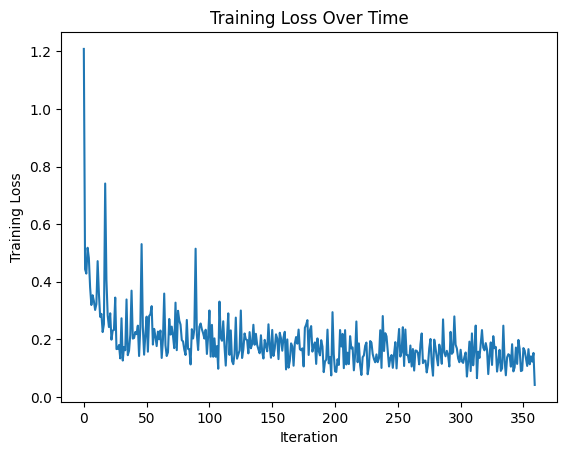

In [14]:
# Plot the training loss
plt.plot(train_losses)
plt.xlabel('Iteration')
plt.ylabel('Training Loss')
plt.title('Training Loss Over Time')
plt.show()

In [15]:
torch.save(model.state_dict(), 'model_weights.pth')